# Chapter 6: The Haunted DAG & The Causal Terror - Samples

Imagine how selecting topics for a conference works. Imagine that we are scoring with equal weights on two variables:

* Trustworthiness
* Newsworthiness

Let's simulate:

#### Code 6.1

In [1]:
import numpy as np
from scipy import stats

np.random.seed(42)
N = 200
p = 0.1
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw
q = np.quantile(s, 1-p)
selected = np.where(s >= q, True, False)
stats.pearsonr(tw[selected], nw[selected])

PearsonRResult(statistic=-0.702031027987863, pvalue=0.0005597087444959316)

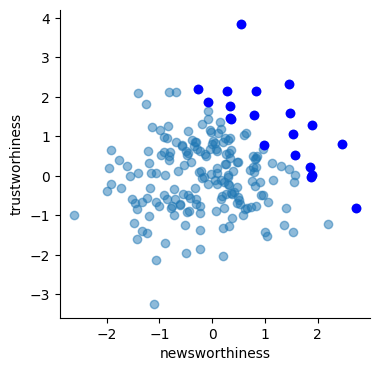

In [2]:
from matplotlib import pyplot as plt


plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.plot(nw, tw, 'o', alpha=0.5)
ax.plot(nw[selected], tw[selected], 'bo');
ax.set_xlabel('newsworthiness')
ax.set_ylabel('trustworhiness')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

> <span style="color:blue">BERKSON'S PARADOX</span>. Among funded proposals, the most newsworthy studies can actually have less than average trustworhiness (less than 0 in the figure). Is is also known as the **selection-distortion effect**.

> <span style="color:blue">COLLIDER BIAS</span>. Regression will not help finding these scenarios because the act of adding a predictor induces statistical selection within the model.

In this chapter we will investigate three types of ☢️ hazards:
* Multicollinearity;
* Post-treatment bias;
* Collider bias.

## Multicollinearity

What would happen if we add all the variables into a multiregression problem?

> <span style="color:blue">MULTICOLLINARITY</span>. A very strong association between two or more predictor variables.

Our posterior distribution might suggest that none of the variables are  reliably associated with the outcome, even if all of them are.

### Multicollinear Legs

Let's try out an example. Let's relate height (outcome) with both left and right leg size.

#### Code 6.2

In [3]:
import pandas as pd

N = 100
np.random.seed(42)
height = np.random.normal(size=N, loc=10, scale=2)
leg_prop = np.random.uniform(size=N, low=0.4, high=0.5)
leg_left = leg_prop * height + np.random.normal(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + np.random.normal(size=N, loc=0, scale=0.02)

d = pd.DataFrame({
    'height': height,
    'leg_left': leg_left,
    'leg_right': leg_right,
})
d.head()

,height,leg_left,leg_right
0,10.993428,4.856509,4.860230
1,9.723471,4.134425,4.093350
2,11.295377,4.648250,4.654939
3,13.046060,5.713282,5.651172
4,9.531693,4.723943,4.713700


The average of leg size is 0.45 the height of a person. So we would expect one of the $\beta$ coefficients in a linear regression to be 0.45. But in this case the other one would have to be 0. But of course this is not what happens.

In [4]:
import pymc as pm
from rethinking import precis

In [5]:
def quap(model):
    vars_ = [
        var 
        for val in model.value_vars 
        for var, values in model.rvs_to_values.items() 
        if val == values
    ]
    var_names = [v.name for v in vars_]
    mean_q = pm.find_MAP()
    H = pm.find_hessian(mean_q, vars_)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
    posterior = stats.multivariate_normal(mean=mean, cov=cov)
    return posterior, vars_

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('bl', 2, 10)
    br = pm.Normal('br', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)
    h = pm.Normal('h', mu, sigma, observed=height)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
post_data = pd.DataFrame(post.rvs(10_000), columns=var_names)
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.575074,0.071162,0.460143,0.690108
bl,-0.568324,1.941735,-3.666379,2.528072
br,2.495270,1.943369,-0.605199,5.612881
a,1.308760,0.291572,0.846473,1.774103


The results are very spread. Let's display the posterior means.

#### Code 6.4

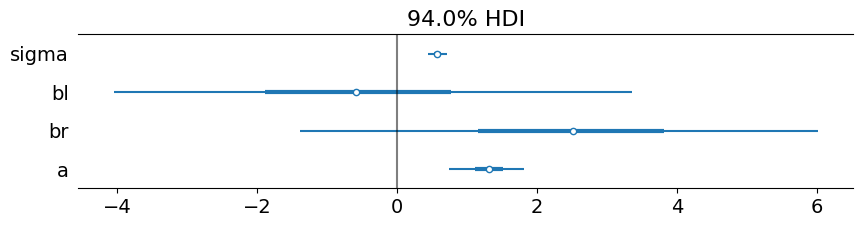

In [6]:
import arviz as az

az.plot_forest(post_data.to_dict('list'), figsize=(10, 2));
plt.axvline(0, color='black', alpha=0.5);

*What is the value of knowing each leg's length, after already knowing the other leg's length*.

#### Code 6.5

Look at the combinations.

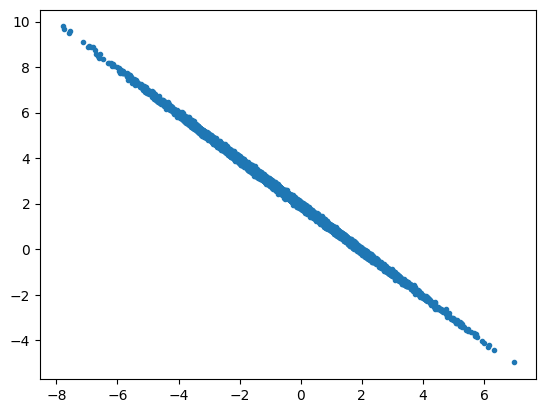

In [7]:
plt.plot(post_data['bl'], post_data['br'], '.');

If we insist on having both variables in the model, then there are an infinite number of combinations possible.

One way to look at this problem, is thinking that we have worked on the following mathematical formula:

$$
\begin{aligned}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_1x_i + \beta_2x_i \\
\end{aligned}
$$

Which is equivalent to

$$\mu_i = \alpha + (\beta_1 + \beta_2)x_i$$

Our posterior has still managed to produce a good enough approximation for this sum.

#### Code 6.6

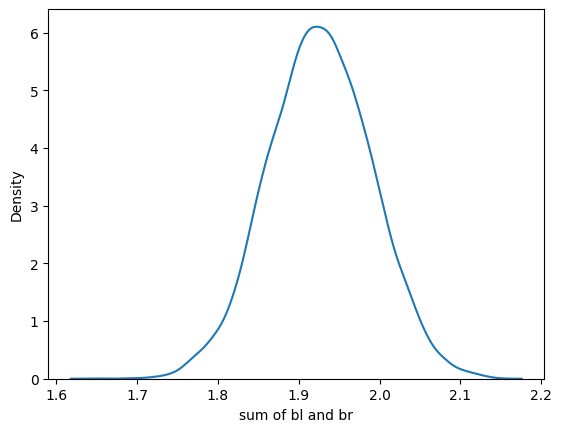

In [8]:
import seaborn as sns

sum_blbr = post_data['br'] + post_data['bl']
sns.kdeplot(sum_blbr);
plt.xlabel('sum of bl and br');

Fitting a regression with only one leg length will get us the same posterior mean.

#### Code 6.7

In [9]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * leg_left)
    h = pm.Normal('h', mu, sigma, observed=height)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.578928,0.069809,0.467776,0.688791
bl,1.924182,0.065074,1.821071,2.029415
a,1.325620,0.291794,0.856952,1.791115


#### Conclusion

When two predictor variables are strongly correlated, including both in the model may lead to confusion. The model will tell us that it can't answer our question. If we are only interested in predictions, then the model will work well, it just won't tell us which leg is more important.

### Multicollinear milk

In real data sets we may not anticipate a clash between highly correlated predictors.

Let's return to the milk problem.

#### Code 6.8

In [10]:
from rethinking import DATA_PATH, standardize

In [11]:
d = pd.read_csv(DATA_PATH.joinpath('milk.csv'), sep=';')
Ko = standardize(d['kcal.per.g'])
F = standardize(d['perc.fat'])
L = standardize(d['perc.lactose'])

We start by modeling `kcal.per.g` as a function of `perc.fat` and `perc.lactose` in two bivariate regressions.

#### Code 6.9

In [12]:
with pm.Model() as model_F:
    sigma = pm.Exponential('sigma', 1)
    bF = pm.Normal('bF', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bF * F)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model_F)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.451363,0.130841,0.241485,0.660401
bF,0.861216,0.084373,0.725412,0.996551
a,0.000061,0.077326,-0.122470,0.122972


In [13]:
var_names = [v.name for v in vars_]
precis(post, var_names)

with pm.Model() as model_L:
    sigma = pm.Exponential('sigma', 1)
    bL = pm.Normal('bL', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bL * L)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model_L)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.379333,0.130351,0.171606,0.587546
bL,-0.903061,0.071867,-1.017254,-0.788865
a,-0.001046,0.066292,-0.107200,0.104048


Both Lactose and Fat have good predictor power only in different directions. But what happens if we join both?

#### Code 6.10

In [14]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bL = pm.Normal('bL', 0, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bL * L + bF * F)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.377478,0.129960,0.169789,0.586616
bL,-0.679042,0.181998,-0.967314,-0.388616
bF,0.244027,0.181516,-0.045325,0.534545
a,-0.000942,0.066098,-0.106204,0.106062


This is the same phenomenon as in the legs example. To simplify the visualization of it, we can use a **pairs plot**.

#### Code 6.11

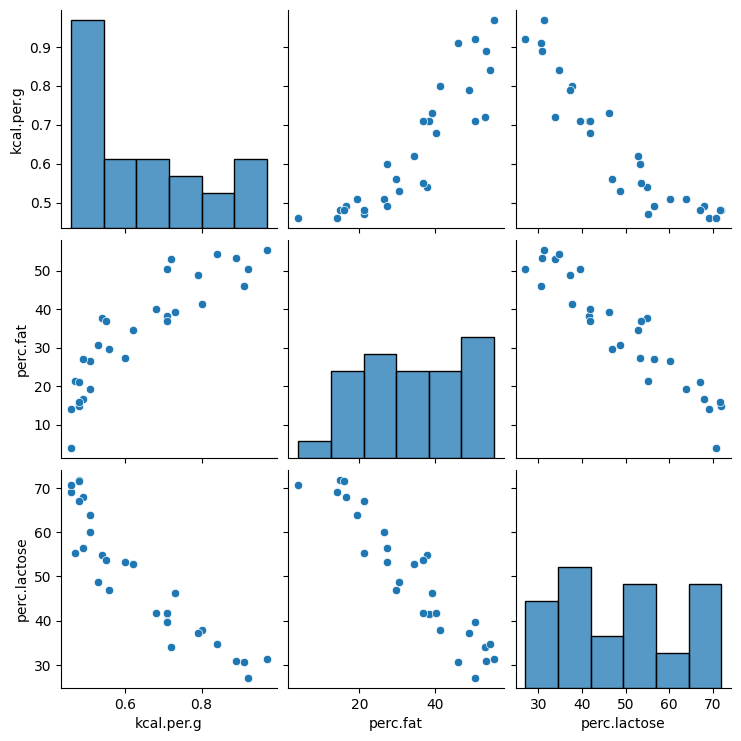

In [15]:
sns.pairplot(d[["kcal.per.g", "perc.fat", "perc.lactose"]]);

In the middle row and right-most plot, we can see that `perc.fat` and `perc.lactose` have a very high correlation, which means that knowing one, makes the use of the other predictor redundant.

> Pairwise correlations are not the problem. It is the conditional associations—not correlations—that matter.

In this case, it is more likely that another variable influences both Lactose and Fat and these influence the Kilocalories.

> <span style="color:blue">NON-IDENTIFIABILITY</span>. Family of problems where multicollinearity belongs. These problems exist when data or model make it impossible to identify the value of parameters.

#### Code 6.12

Simulating multicollinearity

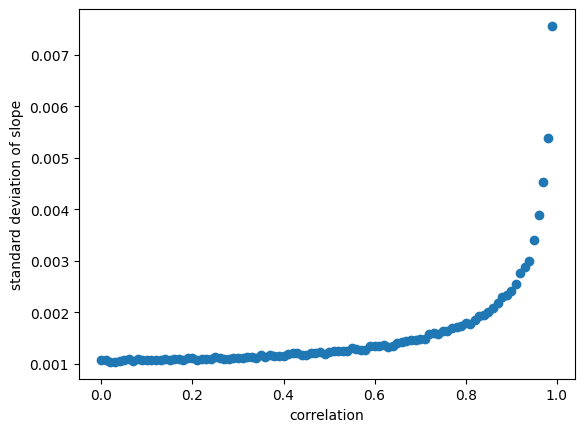

In [16]:
from scipy.optimize import curve_fit


def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

## Post-treatment bias

It is a problem both by including too many variables, as it is including too few.

> <span style="color:blue">OMITTED VARIABLE BIAS</span>. Happens when we do mistaken inferences from **omitting** predictor variables.

> <span style="color:blue">INCLUDED VARIABLE BIAS</span>. Happens when we do mistaken inferences from **including** predictor variables.

> <span style="color:blue">POST TREATMENT BIAS</span>. It's a type of **included variable bias**.

Let's imagine doing plant treatment. We have four variables: initial height, final height, treatment and presence of fungus. Final height is the outcome, but fungus is the *post-treatment effect*. Let's simulate:

#### Code 6.13

In [17]:
def precis_df(data):
    # Gather the data
    mean_ = data.mean()
    std_ = data.std()
    quantile055 = data.quantile(0.055)
    quantile945 = data.quantile(0.945)
    
    precis_table = pd.concat([
        mean_, std_, quantile055, quantile945], axis=1)
    
    precis_table.columns = [
        'mean', 'std', '5.5%', '94.5%'
    ]
    return precis_table

# number of Plants
N = 100

# simulate initial heights
h0 = np.random.normal(size=N, loc=10, scale=2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N/2)
fungus = np.random.binomial(size=N, n=1, p=0.5-treatment*0.4)
h1o = h0 + np.random.normal(size=N, loc=5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({'h0': h0, 'h1': h1o, 'treatment': treatment, 'fungus': fungus})
precis_df(d)

,mean,std,5.5%,94.5%
h0,10.055778,2.006780,7.060523,13.474543
h1,13.819175,2.503224,9.661502,17.790590
treatment,0.500000,0.502519,0.000000,1.000000
fungus,0.400000,0.492366,0.000000,1.000000


### A prior is born

Let's focus now only on the height variables.

$$
\begin{aligned}
h_{1,i} &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= h_{0,i} \times p
\end{aligned}
$$

If $p=1$ than the plant hasn't changed at all from time 0 to time 1. We need to make sure the prior is always bigger than 0, so we can use the Log-Normal.

#### Code 6.14

In [18]:
sim_p = np.random.lognormal(size=10_000, mean=0, sigma=0.25)
precis_df(pd.DataFrame({'sim_p': sim_p}))

,mean,std,5.5%,94.5%
sim_p,1.029713,0.261703,0.664548,1.4846


This prior expects anything from 40% shrinkage to 50% growth.
Let's fit this model.

#### Code 6.15

In [19]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    p = pm.LogNormal('p', 0, 0.25)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu, sigma, observed=h1o)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.907273,0.069773,1.796228,2.019051
p,1.355229,0.013864,1.332991,1.377374


This is about 40% growth. Now we can include the treatment and fungus variable. Since these variables are also on the proportion scale, they will be changes.

$$
\begin{aligned}
h_{1,i} &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= h_{0,i} \times p \\
p &= \alpha + \beta_TT_i + \beta_FF_i \\
\alpha &\sim \text{Log-Normal}(0, 0.25) \\
\beta_T &\sim \text{Normal}(0, 0.5) \\
\beta_F &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\end{aligned}
$$

Let's check the priors.

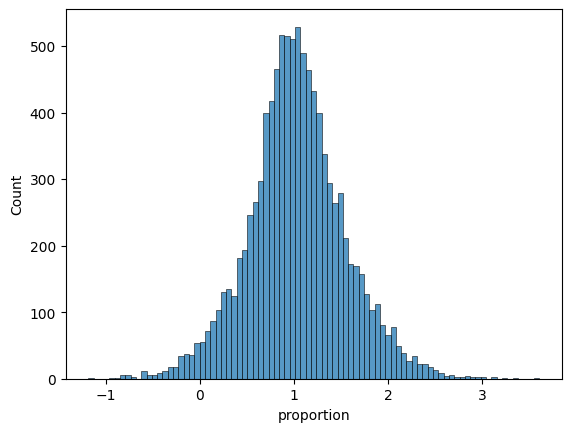

In [20]:
N = 10_000

treatment_sim = np.repeat([0, 1], N/2)
fungus_sim = np.random.binomial(size=N, n=1, p=0.5-treatment_sim*0.4)

a = np.random.lognormal(size=N, mean=0, sigma=0.25)
bT = np.random.normal(size=N, loc=0, scale=0.5)
bF = np.random.normal(size=N, loc=0, scale=0.5)
sns.histplot(a + bT*treatment_sim + bF*fungus_sim)
plt.xlabel('proportion');

#### Code 6.16

Approximate the posterior.

In [21]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, 0.25)
    bF = pm.Normal('bF', 0, 0.5)
    bT = pm.Normal('bT', 0, 0.5)
    p = pm.Deterministic('p', a + bT*treatment + bF * fungus)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu, sigma, observed=h1o)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.342518,0.069675,1.228483,1.453220
a,1.471722,0.018679,1.442198,1.501534
bF,-0.270817,0.031188,-0.320910,-0.221778
bT,-0.003649,0.030496,-0.052681,0.045348


#### Conclusion

The treatment seems to not have any effect, and the fungus seems to have a detrimental effect.

### Blocked by consequence

*Once we already know whether or not a plant developed fungus, does soil treatment matter?*

No.


To measure the true effect of treatment on growth, we need to ommit the fungus variable.

#### Code 6.17

In [22]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, 0.25)
    bT = pm.Normal('bT', 0, 0.5)
    p = pm.Deterministic('p', a + bT*treatment)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu, sigma, observed=h1o)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.775288,0.069978,1.664097,1.888522
a,1.289879,0.018542,1.260642,1.319631
bT,0.138629,0.034806,0.082196,0.193859


Now we see that the impact of treatment is clearly positive.

If we want to do a correct inference, we need to omit any post-treatment variable, so it doesn't zero the coefficient of the treatment.

### Fungus and d-separation

We can look at this through a DAG.

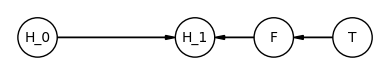

In [23]:
import daft
from causalgraphicalmodels import CausalGraphicalModel

dag = CausalGraphicalModel(nodes=['H_0', 'H_1', 'F', 'T'], edges=[('H_0', 'H_1'), ('F', 'H_1'), ('T', 'F')])
pgm = daft.PGM()
coordinates = {'H_0': (0, 0), 'H_1': (2, 0), 'F': (3, 0), 'T': (4, 0)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

We can say that conditioning on $F$ induces <span style="color:blue">D-SEPARATION</span>. $d$ stands for directional. 

We can also check for <span style="color:blue">CONDITIONAL INDEPENDENCIES</span>.

#### Code 6.19

In [24]:
for ind in dag.get_all_independence_relationships():
    print(ind)

('H_1', 'T', {'F'})
('H_1', 'T', {'H_0', 'F'})
('H_0', 'F', set())
('H_0', 'F', {'T'})
('H_0', 'T', set())
('H_0', 'T', {'F'})
('H_0', 'T', {'H_1', 'F'})


Now let's check a case where another unobserved variable influences both height and fungus, such as moisture.

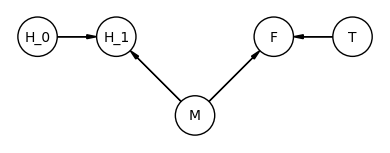

In [25]:
dag = CausalGraphicalModel(nodes=['H_0', 'H_1', 'F', 'T', 'M'], edges=[('H_0', 'H_1'), ('M', 'H_1'), ('M', 'F'), ('T', 'F')])
pgm = daft.PGM()
coordinates = {'H_0': (0, 0), 'H_1': (1, 0), 'F': (3, 0), 'T': (4, 0), 'M': (2, 1)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

We can create data for this scenario.

#### Code 6.20

In [26]:
np.random.seed(7000)
N = 1_000
h0 = np.random.normal(size=N, loc=10, scale=2)
treatment = np.repeat([0, 1], N/2)
M = np.random.binomial(size=N, n=1, p=0.5)
fungus = np.random.binomial(size=N, n=1, p=0.5-treatment*0.4 + 0.4*M)
h1o = h0 + np.random.normal(size=N, loc=5-3*M)

# compose a clean data frame
d2 = pd.DataFrame({'h0': h0, 'h1': h1o, 'treatment': treatment, 'fungus': fungus})
precis_df(d2)

,mean,std,5.5%,94.5%
h0,9.930733,2.016282,6.790684,13.223194
h1,13.432331,2.792110,8.849412,17.973383
treatment,0.500000,0.500250,0.000000,1.000000
fungus,0.476000,0.499674,0.000000,1.000000


In [27]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, 0.25)
    bF = pm.Normal('bF', 0, 0.5)
    bT = pm.Normal('bT', 0, 0.5)
    p = pm.Deterministic('p', a + bT*treatment + bF * fungus)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu, sigma, observed=h1o)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.814980,0.022038,1.779727,1.850338
a,1.417508,0.007884,1.404931,1.430006
bF,-0.133240,0.012162,-0.152229,-0.113509
bT,-0.028192,0.012179,-0.047703,-0.008580


In [28]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, 0.25)
    bT = pm.Normal('bT', 0, 0.5)
    p = pm.Deterministic('p', a + bT*treatment)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu, sigma, observed=h1o)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.919790,0.022285,1.883952,1.955508
a,1.329760,0.006230,1.319792,1.339670
bT,0.021831,0.011907,0.002782,0.040862


## Collider Bias

We can now pick up again on **Berkson's Paradox**. Collider Bias happens when we have two variables causing another, and we try to predict one of those variables using the other, and the one being caused (the collider).

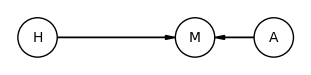

In [29]:
dag = CausalGraphicalModel(nodes=['H', 'M', 'A'], edges=[('H', 'M'), ('A', 'M')])
pgm = daft.PGM()
coordinates = {'H': (0, 0), 'M': (2, 0), 'A': (3, 0)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

Here's another simulation imagine the following:

1. Each year, 20 people are born with uniformly distributed happiness values.
2. Each year, each person ages one year. Happiness does not change.
3. At age 18, individuals can become married. The odds of marriage each year are proportional to an individual's happiness.
4. Once married, an individual remains married.
5. After age 65, individuals leave the sample. (They move to Spain.)

#### Code 6.21

In [36]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=['age', 'happiness', 'married'])
    popn.loc[:, 'age'] = np.repeat(np.arange(65), 20)
    popn.loc[:, 'happiness'] = np.repeat(np.linspace(-2, 2, 20), 65)

    for i in range(N_years):
        # age population
        popn.loc[:, 'age'] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, 'age'] = 0
        popn.loc[ind, 'married'] = 0
        popn.loc[ind, 'happiness'] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, 'happiness'] - 4))
        popn.loc[elligible, 'married'] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [38]:
d = sim_happiness(N_years=1000)
precis_df(d)

,mean,std,5.5%,94.5%
age,3.200000e+01,18.768883,3.000000,61.000000
happiness,-8.471856e-17,1.214421,-1.789474,1.789474
married,2.700000e-01,0.444130,0.000000,1.000000


We can now consider a multiple regression aimed at inferring the influence of age on happiness, while controling for marriage status.

$$\mu_i = \alpha_{\text{MID}[i]} + \beta_AA_i$$

It is easier if we rescale age and consider only grown ups.

#### Code 6.22

In [59]:
d2 = d[d['age'] > 17]
mid = d2['married'].values
A = (d2['age'] - 18) / (65 - 18)

We can then approximate the posterior and investigate the results.

#### Code 6.23

In [60]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0, 1, shape=2)
    bA = pm.Normal('bT', 0, 2)
    mu = pm.Deterministic('mu', a[mid.astype(int)] + bA*A)
    happiness = pm.Normal('happiness', mu, sigma, observed=d2['happiness'].values)
    post, vars_ = quap(model)

precis(post, ['sigma', 'a0', 'a1', 'bT'])

,mean,std,5.5%,94.5%
sigma,1.022308,0.022893,0.985597,1.058457
a0,-0.158549,0.065749,-0.264395,-0.054821
a1,1.264552,0.090883,1.116965,1.409328
bT,-0.763098,0.119677,-0.954020,-0.573036


This model shows that age is negatively associated with happiness. We'd like to compare the inferences from this model to one that omits marriage status.

In [62]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0, 1)
    bA = pm.Normal('bT', 0, 2)
    mu = pm.Deterministic('mu', a + bA*A)
    happiness = pm.Normal('happiness', mu, sigma, observed=d2['happiness'].values)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.213255,0.022995,1.176016,1.250426
a,-0.000911,0.077323,-0.124268,0.122193
bT,0.001533,0.136025,-0.212921,0.217801


This model however, finds no association between age and happiness. This is the kind of pattern we would expect when we condition on a **collider**.

### The Haunted DAG

Collider arises when we condition on a common consequence.

Let's imagine another example. Grandparents education influence Parents education and Children education. But we also get another variable that is hidden and influences both parents and children, and that is Neighborhood.

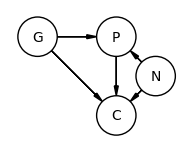

In [77]:
dag = CausalGraphicalModel(nodes=['G', 'P', 'C', 'N'], edges=[('G', 'P'), ('G', 'C'), ('P', 'C'), ('N', 'P'), ('N', 'C')])
pgm = daft.PGM()
coordinates = {'G': (0, 0), 'P': (1, 0), 'C': (1, 1), 'N': (1.5, 0.5)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

Let's simulate 200 triads of grandparents, parents and children. This simulation is simple.

#### Code 6.25

In [78]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

Grandparents might have bigger than 0, but we consider 0 to make this example easier to understand.

Let's draw random observations.

#### Code 6.26

In [79]:
np.random.seed(42)
U = 2 * np.random.binomial(n=1, size=N, p=0.5) - 1
G = np.random.normal(size=N)
P = np.random.normal(size=N, loc=b_GP*G + b_U*U)
C = np.random.normal(size=N, loc=b_GC*G + b_U*U + b_PC*P)
d = pd.DataFrame({'C': C, 'P': P, 'G': G, 'U': U})
d.head()

,C,P,G,U
0,-2.654583,-1.822365,-0.680025,-1
1,4.326736,2.072315,0.232254,1
2,4.611659,2.274056,0.293072,1
3,1.871242,0.283119,-0.714351,1
4,-2.640345,-0.152739,1.865775,-1


Pushing forward in this example.

#### Code 6.27

In [80]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    b_PCi = pm.Normal('b_PCi', 0, 1)
    b_GCi = pm.Normal('b_GCi', 0, 1)
    a = pm.Normal('a', 0, 1)
    mu = pm.Deterministic('mu', a + b_PCi*P + b_GCi*G)
    Co = pm.Normal('Co', mu, sigma, observed=C)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.278510,0.050151,1.197799,1.357814
b_PCi,1.810336,0.040614,1.745774,1.874496
b_GCi,-0.814618,0.101684,-0.975223,-0.652217
a,0.007354,0.089374,-0.134447,0.148578


Our model assumes that Grandparents have a negative association with Children. But this only happens because Grandparents well educated have well educated parents that are both in good and in bad neighborhoods. This might lead to more non-educated children related to well educated grandparents, making it seem that well educated grandparents have a bad influence on children.

What would happen if we join everything?

#### Code 6.28

In [81]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    b_PCi = pm.Normal('b_PCi', 0, 1)
    b_GCi = pm.Normal('b_GCi', 0, 1)
    U_i = pm.Normal('U_i', 0, 1)
    a = pm.Normal('a', 0, 1)
    mu = pm.Deterministic('mu', a + b_PCi*P + b_GCi*G + U_i*U)
    Co = pm.Normal('Co', mu, sigma, observed=C)
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,1.000218,0.050077,0.920080,1.079962
b_PCi,1.112260,0.069453,1.000577,1.223630
b_GCi,-0.178804,0.097808,-0.335816,-0.025601
U_i,1.754096,0.155032,1.505862,2.002953
a,-0.019760,0.070804,-0.133217,0.093094


## Confronting Confounding

We should watch out for the multiple types of confounding that can happen and illude our causal analysis.

### Shutting the backdoor

This is known for blocking confounding paths so we can get the right causal effect on the output. There are only four types of relationships to worry about:

1. The Fork
2. The Pipe (post-treatment bias)
3. The Collider
4. The Descendant

Colliders create closed paths, and we should only be careful not to *activate* them by shoving all variables in the Multiple Regression.

### Two Roads

Let's consider the following DAG.

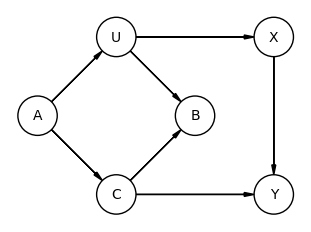

In [83]:
dag = CausalGraphicalModel(
    nodes=['X', 'Y', 'C', 'U', 'B', 'A'],
    edges=[
        ('X', 'Y'),
        ('U', 'X'),
        ('A', 'U'),
        ('A', 'C'),
        ('C', 'Y'),
        ('U', 'B'),
        ('C', 'B'),
    ],
)
pgm = daft.PGM()
coordinates = {'X': (3, 0), 'Y': (3, 2), 'C': (1, 2), 'U': (1, 0), 'B': (2, 1), 'A': (0, 1)}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis();

We can't condition on U since it is unobserved, and B would activate the Collider bias. So, we can only use A or C to condition and close this backdoor.

#### Code 6.29

In [86]:
all_adjustment_sets = dag.get_all_backdoor_adjustment_sets('X', 'Y')
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {'U'}:
            print(s)

frozenset({'A'})
frozenset({'C'})


We can't know if a DAG is right, but we can know if a DAG is wrong.